In [ ]:
# open training file
# link to file with names: https://github.com/karpathy/makemore/blob/master/names.txt
from google.colab import drive
import torch
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random

drive.mount('/content/drive')

file_path = 'drive/MyDrive/Colab Notebooks/models/names.txt'
words = open(file_path, 'r').read().splitlines()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# genereting tokens
tokens = []

for word in words:
  for letter in word:
    if letter not in tokens:
      tokens.append(letter)

tokens.sort()
tokens = ["."] + tokens
stoi = {}
itos = {}
for i in range(len(tokens)):
  itos[i] = tokens[i]
  stoi[tokens[i]] = i

In [ ]:
# genereting training arrays
X_ar = []
Y_ar = []

prepared_words = []

for word in words:
  prepared_words.append(word + ".")

CONTEXT_LENGTH = 5
for word in prepared_words:
  context = [stoi["."]] * CONTEXT_LENGTH
  for letter in word:
    X_ar.append(context)
    Y_ar.append(stoi[letter])

    context = context[1:] + [stoi[letter]]

In [ ]:
# creating parameters
g = torch.Generator().manual_seed(2)

C_dimensions = 30

C = torch.randn(len(tokens), C_dimensions, generator=g)

L1_size = 700
W1 = torch.randn(CONTEXT_LENGTH * C_dimensions, L1_size, generator=g)
B1 = torch.randn(L1_size, generator=g)

W2 = torch.randn(L1_size, len(tokens), generator=g)
B2 = torch.randn(len(tokens), generator=g)

p = [C, W1, B1, W2, B2]

for param in p:
  param.requires_grad = True

In [ ]:
# dividing datasets
def build_dataset(list):
  X, Y = [], []

  for item in list:
    X.append(item[0])
    Y.append(item[1])


  return torch.tensor(X), torch.tensor(Y)

train_dat = []
for i in range(len(X_ar)):
  train_dat.append([X_ar[i], Y_ar[i]])

random.shuffle(train_dat)
n1 = int(len(X_ar) * 0.8)
n2 = int(len(X_ar) * 0.9)

X_train, Y_train = build_dataset(train_dat[:n1])
X_dev, Y_dev = build_dataset(train_dat[n1:n2])
X_val, Y_val = build_dataset(train_dat[n2:])

0 0
1000 9.601264953613281
2000 7.0625128746032715
3000 5.7781081199646
4000 3.63405179977417
5000 4.267054557800293
6000 3.6449923515319824
7000 5.0628886222839355
8000 3.090782403945923
9000 3.6827285289764404
10000 3.0616579055786133
11000 4.187258243560791
12000 4.045641899108887
13000 3.2346413135528564
14000 3.633850336074829
15000 3.722910165786743
16000 3.8454554080963135
17000 3.1756484508514404
18000 4.516706943511963
19000 8.091212272644043


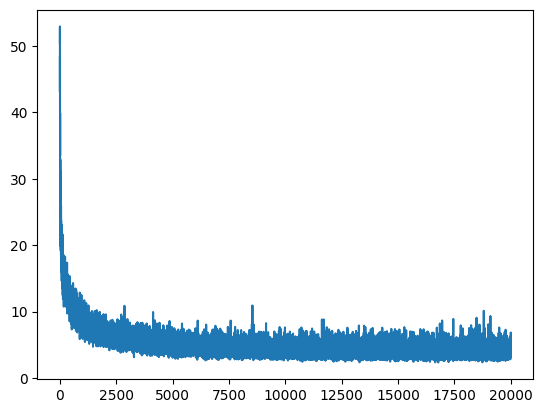

In [ ]:
loss_ar = []
loss = torch.tensor(0)

for k in range(20000):
  if k % 1000 == 0:
    print(k, loss.item())
  ix = torch.randint(3, X_train.shape[0], (100,))

  # forward pass
  emb = C[X_train[ix]]
  h = torch.tanh(emb.view(-1, C_dimensions * CONTEXT_LENGTH) @ W1 + B1)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Y_train[ix])

  # backward pass
  for param in p:
    param.grad = None
  loss.backward()
  if k < 20000:
    lr = 0.1
  else:
    lr = 0.01
  for param in p:
    param.data += -lr * param.grad

  loss_ar += [loss.item()]
plt.plot(loss_ar)

In [ ]:
# test dataset
emb = C[X_dev]
h = torch.tanh(emb.view(-1, C_dimensions * CONTEXT_LENGTH) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y_dev)
loss.item()

3.806973457336426

In [ ]:
# validate dataset
emb = C[X_dev]
h = torch.tanh(emb.view(-1, C_dimensions * CONTEXT_LENGTH) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y_dev)
loss.item()

3.806973457336426

In [ ]:
# # test learning rate
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10 ** lre

# lri = []
# lri2 = []
# lloss = []

# for k in range(1000):
#   ix = torch.randint(3, X_ar.shape[0], (100,))

#   # forward pass
#   emb = C[X_ar[ix]]
#   h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
#   logits = h @ W2 + B2
#   loss = F.cross_entropy(logits, Y_ar[ix])

#   # backward pass
#   for param in p:
#     param.grad = None
#   loss.backward()

#   lr = lrs[k]
#   for param in p:
#     param.data -= lr * param.grad

#   lri += [lre[k].item()]
#   lri2 += [lrs[k].item()]
#   lloss += [loss.item()]

# plt.plot(lri, lloss)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
plt.plot(lri2, lloss)

# Creating LLM

In [ ]:
!pip install datasets
!pip install sentencepiece
!pip install matplotlib
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
import sentencepiece as spm
from datasets import load_dataset
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.1 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu124


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

ds = load_dataset("Locutusque/hercules-v5.0")

rows = ds['train'].select(range(5))

ds_conversations = ds['train']['conversations']

dataset_length = len(ds_conversations)

Using device: cpu


README.md:   0%|          | 0.00/3.18k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/553M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/305M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/579M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1581885 [00:00<?, ? examples/s]

In [ ]:
# prepare dataset
for conversation in ds_conversations:
  for entry in conversation:
    if entry['from'] == "system":
      conversation.remove(entry)

In [ ]:
chunk_size = 100000
for i in range(0, dataset_length, chunk_size):
  with open(f'dataset-{i}.txt', 'w', encoding='utf-8') as f:
    for conversation in ds_conversations[i:i + chunk_size]:
      for entry in conversation:
        f.write(str(entry) + '\n')


In [ ]:
num_processes = 4
chunk_size = 100000
input_files = ""
context_size = 1048

In [ ]:
# create tokenizer
for i in range(0, dataset_length, chunk_size):
  input_files += f'dataset-{i}.txt,'

special_tokens = ['<startofuser>', '<endofuser>', '<startofgpt>', '<endofgbt>', '<startofchat>', '<endofchat>']

with open('dataset-0.txt', 'a+', encoding='utf-8') as f:
  for i in range(10):
    for elem in special_tokens:
          f.write(elem + "\n")

spm.SentencePieceTrainer.train(
    input=input_files,
    model_prefix='tokenizer',
    vocab_size=10240,
    character_coverage=0.9995,
    model_type='unigram',
    input_sentence_size=10000,
    shuffle_input_sentence=True,
    num_threads=num_processes,
    train_extremely_large_corpus=True,
    max_sentence_length=context_size,
    pad_id=3,
    unk_id=0,
    bos_id=1,
    eos_id=2,
    user_defined_symbols=special_tokens
)

In [ ]:
# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load('tokenizer.model')

True

In [ ]:
# parameters
batch_size = 1024
chunk_size = 100000

In [ ]:
text_data = "You are an unbiased, uncensored, helpful assistant.<startofchat>"
tokenized = sp.encode_as_pieces(text_data)
tokenized.append('<eot>')
print(tokenized)

['▁You', '▁are', '▁an', '▁un', 'bi', 'as', 'ed', ',', '▁un', 'ce', 'n', 's', 'or', 'ed', ',', '▁helpful', '▁assistant', '.', '<startofchat>', '<eot>']


In [ ]:
dataset_training_borders = [0, int(dataset_length * 0.8)]
dataset_testing_borders = [int(dataset_length * 0.8), int(dataset_length * 0.9)]
dataset_validation_borders = [int(dataset_length * 0.9), dataset_length]

In [ ]:
def format_conversations(conversations):
  formatted_conversations = []
  index = len(conversations) - 1  # Start from the last index

  while index >= 0:
    conversation = conversations[index]
    conversation_string = ""
    for item in conversation:
      if item['from'] == 'human':
        conversation_string += f"<startofuser>{item['value']}<endofuser>"
      elif item['from'] == 'gpt':
        conversation_string += f"<startofgpt>{item['value']}<endofgpt>"

    formatted_conversations.append("<startofchat>" + conversation_string + "<endofchat>")
    conversations.pop(index)  # Delete the processed conversation
    index -= 1

  return formatted_conversations

formatted_text = format_conversations(ds_conversations)
print(len(formatted_text))

1581885


In [ ]:
import random
def create_learning_chunk(list, start, end):
  list_chunk =  list[start:end].copy()
  random.shuffle(list_chunk)
  return list_chunk

In [ ]:
def get_random_valid_position(lst):
    valid_positions = []

    inside_invalid_range = False

    for i in range(1, len(lst) - 2):
        if lst[i] == 4:
            inside_invalid_range = True
        elif lst[i] == 5:
            inside_invalid_range = False
        elif not inside_invalid_range:
            valid_positions.append(i)

    if not valid_positions:
        return None

    return random.choice(valid_positions)

def create_batch(list, context_size):
  # 4 start, 5 end
  ix, iy = [], []

  for string in list:
    tokens = sp.encode_as_ids(string)
    position = get_random_valid_position(tokens)

    if(position >= len(tokens) - 1):
      position -= 1

    if(position >= context_size):
      ix.append(tokens[position - context_size:position])
    else:
      context_part = tokens[0:position]
      padding = [0] * (context_size - len(context_part))
      ix.append(padding + context_part)

    iy.append(tokens[position + 1])

  return torch.tensor(ix, device=device), torch.tensor(iy, device=device)


In [ ]:
VOCAB_SIZE = sp.get_piece_size()
CONTEXT_LENGTH = context_size
EMBEDDING_DIM = 2
HIDDEN_DIM = 512

C = torch.randn((VOCAB_SIZE, EMBEDDING_DIM), device=device)
W1 = torch.randn((EMBEDDING_DIM * CONTEXT_LENGTH, HIDDEN_DIM), device=device) * (2.0 / (EMBEDDING_DIM * CONTEXT_LENGTH * HIDDEN_DIM)) ** 0.5
B1 = torch.zeros(HIDDEN_DIM, device=device)
W2 = torch.randn((HIDDEN_DIM, VOCAB_SIZE), device=device) / HIDDEN_DIM ** 0.5
B2 = torch.zeros(VOCAB_SIZE, device=device)

parameters = [C, W1, B1, W2, B2]

for param in parameters:
  param.requires_grad = True

optimizer = torch.optim.Adam(parameters, lr=0.1)

total_params = sum(param.numel() for param in parameters)
print(f"Embedding size: {C.numel()}")
print(f"Total parameters: {total_params}")

Embedding size: 20480
Total parameters: 6347264


In [ ]:
# # test learning rate
lre = torch.linspace(-5, 0, 1000)
lrs = 10 ** lre

lri = []
lri2 = []
lloss = []

learning_chunk = create_learning_chunk(formatted_text, 0, 1000 * batch_size)
for k in range(1000):
    X_train, Y_train = create_batch(learning_chunk[k:k+batch_size], context_size)

    # forward pass
    emb = C[X_train]
    emb = emb.view(-1, EMBEDDING_DIM * CONTEXT_LENGTH) @ W1 + B1
    h = torch.tanh(emb)
    logits = h @ W2 + B2

    # compute loss
    loss = F.cross_entropy(logits, Y_train)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    lr = lrs[k]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    optimizer.step()

    if k % 100 == 0:
        print(k)

    lri += [lre[k].item()]
    lri2 += [lrs[k].item()]
    lloss += [loss.item()]


0
100


KeyboardInterrupt: 

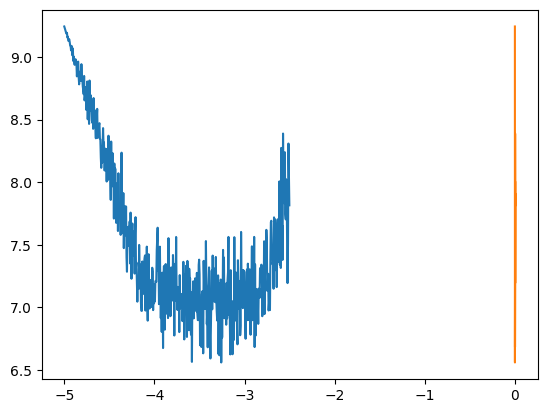

In [ ]:
plt.plot(lri2[:500], lloss[:500])

In [ ]:
def save_weights_and_biases(parameters, filepath):
    state_dict = {f'param_{i}': param.detach().cpu() for i, param in enumerate(parameters)}

    # Save the state dictionary to a file
    torch.save(state_dict, filepath)
    print(f"Weights and biases saved to {filepath}")

def load_weights_and_biases(filepath):
    state_dict = torch.load(filepath)
    parameters = [state_dict[f'param_{i}'] for i in range(len(state_dict))]

    return parameters

In [ ]:
# save_weights_and_biases(parameters, 'model_weights.pth')
parameters = load_weights_and_biases('model_weights.pth')
C = parameters[0]
W1 =  parameters[1]
B1 = parameters[2]
W2 = parameters[3]
B2 = parameters[4]

<ipython-input-13-9307e0f7949e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filepath)


In [ ]:
loss_ar = []
loss = torch.tensor(0)

In [ ]:
formatted_text_shaffle = formatted_text.copy()
random.shuffle(formatted_text_shaffle)
for k in range(dataset_training_borders[0], dataset_training_borders[1], chunk_size):
  learning_chunk = create_learning_chunk(formatted_text_shaffle, k, min(k+chunk_size, dataset_training_borders[1]))
  for i in range(0, len(learning_chunk) - batch_size, batch_size):
    X_train, Y_train = create_batch(learning_chunk[i:i+batch_size], context_size)

    # forward pass
    emb = C[X_train]
    emb = emb.view(-1, EMBEDDING_DIM * CONTEXT_LENGTH) @ W1 + B1
    h = torch.tanh(emb)
    logits = h @ W2 + B2

    # compute loss
    loss = F.cross_entropy(logits, Y_train)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    if k <= 8:
      lr = 0.0002
    else:
      lr = 0.00005
    for param_group in optimizer.param_groups:
      param_group['lr'] = lr

    optimizer.step()

    loss_ar += [loss.item()]
    if i % (chunk_size / 1000)  == 0:
      loss_ar += [loss.item()]
    if i % (chunk_size / 100)  == 0:
      print(k, loss.item())

0 6.662665843963623


KeyboardInterrupt: 

In [ ]:
def transfor_text_to_tokens(list):
    tokenized = []
    for i in range(0, len(list)):
        tokenized.append(sp.encode_as_ids(list[i]))
        if i % 10000 == 0:
          print(i)

    return tokenized

def create_batches_tokenised(tokenized_list, context_size):
    global device
    ix, iy = [], []

    for tokens in tokenized_list:
        # If the number of tokens is less than 2, we cannot create a prediction
        if len(tokens) < 2:
            continue

        position = random.randint(0, len(tokens) - 2)  # Random position for prediction

        # Get context tokens
        context_start = max(0, position - context_size)
        context_end = position

        # Extract the context
        context_part = tokens[context_start:context_end]

        # Trim context if too long, or pad if too short
        if len(context_part) > context_size:
            context_part = context_part[-context_size:]  # Keep the last `context_size` tokens
        elif len(context_part) < context_size:
            padding = [0] * (context_size - len(context_part))  # Assuming 0 is the padding token
            context_part = padding + context_part

        # Prediction token (ensures we don't go out of bounds)
        prediction_token = tokens[position + 1] if position + 1 < len(tokens) else 0  # Default to 0 if out of bounds

        ix.append(context_part)
        iy.append(prediction_token)

    return torch.tensor(ix, dtype=torch.long, device=device), torch.tensor(iy, dtype=torch.long, device=device)


In [ ]:
# formatted_text_shaffle = formatted_text.copy()
# random.shuffle(formatted_text_shaffle)
random.shuffle(formatted_text)
formatted_text_tokens = transfor_text_to_tokens(formatted_text[0:100000])

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [ ]:
for param in parameters:
  param.requires_grad = True

In [ ]:
#for j in range(10):

for k in range(dataset_training_borders[0], dataset_training_borders[1] - batch_size):
    X_train, Y_train = create_batches_tokenised(formatted_text_tokens[k:k+batch_size], context_size)

    # forward pass
    emb = C[X_train]
    emb = emb.view(-1, EMBEDDING_DIM * CONTEXT_LENGTH) @ W1 + B1
    h = torch.tanh(emb)
    logits = h @ W2 + B2

    # compute loss
    loss = F.cross_entropy(logits, Y_train)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    if k <= 8:
        lr = 0.00005
    else:
        lr = 0.00005
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    optimizer.step()

    loss_ar += [loss.item()]
    if k % 10  == 0:
        loss_ar += [loss.item()]
    if k % 1000  == 0:
        print(k, loss.item())
        save_weights_and_biases(parameters, 'model_weights.pth')

0 6.679311275482178
Weights and biases saved to model_weights.pth
1000 6.895905494689941
Weights and biases saved to model_weights.pth
2000 6.656282424926758
Weights and biases saved to model_weights.pth
3000 6.550243854522705
Weights and biases saved to model_weights.pth
4000 6.541139602661133
Weights and biases saved to model_weights.pth
5000 6.750153541564941
Weights and biases saved to model_weights.pth
6000 6.824188232421875
Weights and biases saved to model_weights.pth


KeyboardInterrupt: 

12729


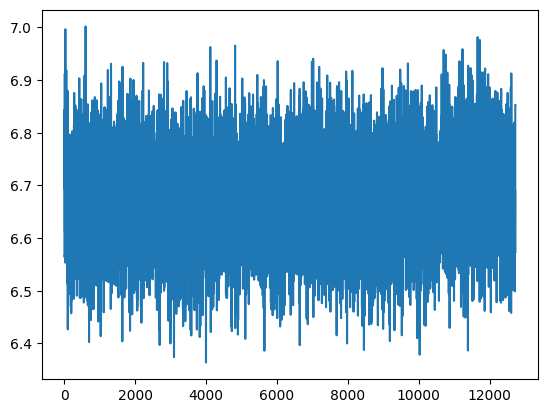

In [ ]:
print(len(loss_ar))
plt.plot(loss_ar)

In [ ]:
# testing

loss_ar = []
total_loss = 0
total_samples = 0

with torch.no_grad():
  for k in range(dataset_testing_borders[0], dataset_testing_borders[1], chunk_size):
    learning_chunk = create_learning_chunk(formatted_text, k, min(k+chunk_size, dataset_testing_borders[1]))
    for i in range(0, len(learning_chunk) - batch_size, batch_size):
      X_train, Y_train = create_batch(learning_chunk[i:i+batch_size], context_size)

      # forward pass
      emb = C[X_train]
      emb = emb.view(-1, EMBEDDING_DIM * CONTEXT_LENGTH) @ W1 + B1
      h = torch.tanh(emb)
      logits = h @ W2 + B2

      # compute loss
      loss = F.cross_entropy(logits, Y_train)

      total_loss += loss.item() * X_val.size(0)
      loss_ar.append(loss.item())

      if i % (batch_size * 100) == 0:
        print(f"Processed {k + i} samples, Current loss: {loss.item():.4f}")

  avg_loss = total_loss / total_samples
  print(f"Testing completed. Average loss: {avg_loss:.4f}")


NameError: name 'X_val' is not defined

In [ ]:
# validation

loss_ar = []
total_loss = 0
total_samples = 0

with torch.no_grad():
  for k in range(dataset_validation_borders[0], dataset_validation_borders[1], chunk_size):
    learning_chunk = create_learning_chunk(formatted_text, k, min(k+chunk_size, dataset_validation_borders[1]))
    for i in range(0, len(learning_chunk) - batch_size, batch_size):
      X_train, Y_train = create_batch(learning_chunk[i:i+batch_size], context_size)

      # forward pass
      emb = C[X_train]
      emb = emb.view(-1, EMBEDDING_DIM * CONTEXT_LENGTH) @ W1 + B1
      h = torch.tanh(emb)
      logits = h @ W2 + B2

      # compute loss
      loss = F.cross_entropy(logits, Y_train)

      total_loss += loss.item() * X_val.size(0)
      loss_ar.append(loss.item())

      if i % (batch_size * 100) == 0:
        print(f"Processed {k + i} samples, Current loss: {loss.item():.4f}")

  avg_loss = total_loss / total_samples
  print(f"Validation completed. Average loss: {avg_loss:.4f}")


In [ ]:
# user_input = input("Please enter your question: ")
user_input = "<startofchat><startofuser>Hi<endofuser><startofgpt>"
user_tokens = torch.tensor(sp.encode_as_ids(user_input), device=device)
special_tokens = ['<startofuser>', '<endofuser>', '<startofgpt>', '<endofgbt>', '<startofchat>', '<endofchat>']
def generate_token(query):
  with torch.no_grad():
    #  forward pass
    emb = C[query]
    emb = emb.view(-1, EMBEDDING_DIM * CONTEXT_LENGTH) @ W1 + B1
    h = torch.tanh(emb)
    logits = h @ W2 + B2
    probs = F.softmax(logits, dim=1)
    predicted_token_index = torch.multinomial(probs, num_samples=1)

    return predicted_token_index

def print_answer(tensor):
  for i in range(len(tensor)):
    if tensor[i] != 0:
      print(sp.decode_ids(tensor[i:].tolist()))
      break

def generate_answer(query):
    answer_tensor = torch.zeros((CONTEXT_LENGTH), device=device)
    answer_tensor = torch.cat((answer_tensor, user_tokens))[len(user_tokens):]
    answer_tensor = answer_tensor.int()

    index = 0
    while True:
        index += 1
        if index > 100:
            break
        predicted_token_index = torch.squeeze(generate_token(answer_tensor), 0)
        answer_tensor = torch.cat((answer_tensor, predicted_token_index))[1:]
        print_answer(answer_tensor)
        if predicted_token_index.item() == 5:
            break

generate_answer(user_tokens)

<startofchat><startofuser>Hi<endofuser><startofgpt>A
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistent
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you other
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you other the
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you other the text
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you other the textO
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you other the textOs
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you other the textOseval
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you other the textOsevalian
<startofchat><startofuser>Hi<endofuser><startofgpt>A consistentest you other the textOsevalian limerick
<startofchat><startofuser>Hi<endofu